# Item2Vec을  이용한 추천
- Item2Vec에 가장 적합한 데이터는 유저 혹은 세션 단위로 비슷한 의도를 가지고 아이템을 소비한 로그입니다
- 무비렌즈 데이터는 Item2Vec을 수행하기에 적합한 데이터는 아니지만 Item2Vec을 통한 연관 추천의 결과가 잘 드러나기 때문에 해당 데이터를 실습으로 사용하겠습니다.

In [1]:
!pip install gensim==4.0.1

     |████████████████████████████████| 23.9 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

import gensim
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
path = '../data/ml-latest-small/'

In [4]:
movies_df = pd.read_csv(path + 'movies.csv')
ratings_df = pd.read_csv(path + 'ratings.csv')

movie_id_to_name = pd.Series(movies_df.title.values, index = movies_df.movieId.values).to_dict()
name_to_movie_id = pd.Series(movies_df.movieId.values, index = movies_df.title).to_dict()

FileNotFoundError: ignored

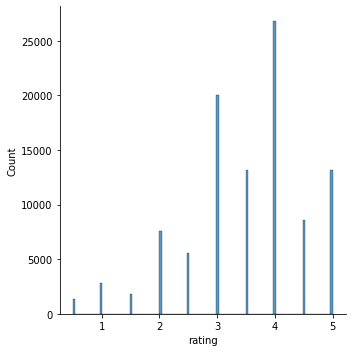

In [ ]:
sns.displot(ratings_df['rating'])

In [ ]:
from sklearn.model_selection import train_test_split

ratings_df['liked'] = np.where(ratings_df['rating'] >= 4, 1, 0)
ratings_df['movieId'] = ratings_df['movieId'].astype('str')
train_df, test_df= train_test_split(ratings_df, stratify=ratings_df['userId'], random_state = 100, test_size=0.20)

In [ ]:
train_df

,userId,movieId,rating,timestamp,liked
78097,484,3911,4.0,1342294787,1
34543,232,48877,3.5,1163024515,0
94410,599,26940,2.5,1519346264,0
85385,555,724,5.0,978745225,1
78341,487,31658,3.5,1428574498,0
...,...,...,...,...,...
79624,495,7163,4.5,1458636189,1
57080,380,1544,4.0,1493667555,1
56692,377,1262,4.5,1340341828,1
96597,603,2118,3.0,953925630,0


In [ ]:
print("number of train data:", len(train_df))
print("number of test data: ", len(test_df))

number of train data: 80668
number of test data:  20168


In [ ]:
# 하나의 유저를 기준으로 4점 이상으로 평가한 영화와 4점 미만으로 평가한 영화를 나누어 각각 Item2Vec 트레이닝 데이터에 사용합니다
user_grouped= train_df.groupby(['liked', 'userId'])
user_movie_list = [user_grouped.get_group(gp)['movieId'].tolist() for gp in user_grouped.groups]

In [ ]:
# 0번 유저의 학습 데이터

user_movie_list[0]

['673',
 '3176',
 '423',
 '223',
 '70',
 '2617',
 '2414',
 '1219',
 '2338',
 '2253',
 '2389',
 '3243',
 '1445',
 '1644',
 '2528',
 '3247',
 '1408',
 '1030',
 '500',
 '2093',
 '1676',
 '1377',
 '736',
 '316']

In [ ]:
len(user_movie_list)

1215

## gensim의 [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- gensim에서 다양한 ML 라이브러리들을 제공합니다
- 그 중에서 가장 많이 사용되는 Word2Vec 라이브러리로 CBOW와 SkipGram을 모두 지원합니다

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences = user_movie_list,
                 epochs = 5,
                 vector_size = 100, # 임베딩을 하는 벡터의 사이즈 (hidden layer의 size)
                 min_count = 3, # 단어가 최소 3회 이상 등장해야 학습되고 모델에 저장됨
                 workers = 4,
                 sg = 1, # skipgram을 사용한다면 1
                 hs = 0, # negative sampling을 사용한다면 0 (hierarchical softmax)
                 negative = 5, # 1개의 positive sample당 negative sample의 개수
                 window = 9999999 # window를 크게 잡는 이유는 문장 내 모든 아이템끼리 학습이 되어야 하기 때문임
                )

word_vectors = model.wv

In [ ]:
# embedding된 아이템의 결과
word_vectors['30793']

array([-0.03982911,  0.03112438,  0.2357419 , -0.07020076,  0.14549406,
       -0.07579914,  0.14308554,  0.03685131,  0.31750447, -0.10678478,
        0.05562659, -0.23670074, -0.21896127,  0.06352498,  0.06774931,
        0.09160338, -0.12982482, -0.20343512, -0.2084784 , -0.03251356,
        0.44000202,  0.17773251,  0.45067957,  0.12219188, -0.18040796,
        0.2265693 , -0.20359759,  0.20224899, -0.33300966,  0.13986519,
        0.32496282,  0.0246326 ,  0.2291629 ,  0.0121108 ,  0.02585655,
       -0.10990229, -0.13991486, -0.00209241,  0.16139458, -0.23708986,
       -0.03004642,  0.18846221,  0.09320308, -0.03957788,  0.19904555,
       -0.27051857, -0.13843891, -0.09186008, -0.02339669,  0.13072409,
       -0.0837856 , -0.37465587, -0.03707303, -0.05092642, -0.23565261,
        0.06434763, -0.14216405, -0.13185053, -0.24941446, -0.12407393,
        0.3327673 , -0.0575984 ,  0.05897082, -0.00653366,  0.00140041,
        0.14190575,  0.23448856, -0.05082029, -0.15134968,  0.02

## 주어진 아이템에 대한 연관 추천
- 주어진 아이템 벡터와 가장 비슷한 아이템 벡터를 찾는 테스크입니다.
- Item2Vec와 MF 모두 아이템 벡터를 생성하는 테스크라고 볼 수 있으며 지난 시간에 배운 annoy도 사용할 수 있습니다.

In [ ]:
# Charlie and the Chocolate Factory (2005)
movies_df[movies_df.movieId == 30793]

,movieId,title,genres
5735,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


In [ ]:
# 주어진 아이템에 대해서 비슷한 아이템을 cosine 유사도로 구합니다

topn = 10
positive_list = ['30793']
similar_movies = model.wv.most_similar(positive=positive_list, topn=topn)

In [ ]:
similar_movies

[('32657', 0.6740508079528809),
 ('8368', 0.656617283821106),
 ('71462', 0.6522750854492188),
 ('42734', 0.6487725973129272),
 ('69644', 0.6456575989723206),
 ('116897', 0.6439380049705505),
 ('8644', 0.6417361497879028),
 ('26903', 0.6406915783882141),
 ('7147', 0.6363593339920044),
 ('38304', 0.6358469128608704)]

In [ ]:
similar_movie_list = [movie_id for movie_id, score in similar_movies]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
4796,7147,Big Fish (2003),Drama|Fantasy|Romance
5166,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
5265,8644,"I, Robot (2004)",Action|Adventure|Sci-Fi|Thriller
5596,26903,Whisper of the Heart (Mimi wo sumaseba) (1995),Animation|Drama|Romance
5858,32657,"Man Who Planted Trees, The (Homme qui plantait...",Animation|Drama
6022,38304,No Direction Home: Bob Dylan (2005),Documentary
6112,42734,Hoodwinked! (2005),Animation|Children|Comedy
7069,69644,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...
7144,71462,"Cove, The (2009)",Documentary
8575,116897,Wild Tales (2014),Comedy|Drama|Thriller


In [ ]:
# Paris, I Love You (Paris, je t'aime) (2006)
# P.S. I Love You (2007)

movies_df[movies_df['movieId'].isin([50912, 56941])]

,movieId,title,genres
6406,50912,"Paris, I Love You (Paris, je t'aime) (2006)",Romance
6657,56941,P.S. I Love You (2007),Comedy|Drama|Romance


In [ ]:
# 2개 이상의 아이템에 대해서는 해당 아이템 벡터들의 element-wise 평균을 구하여 cosine simliarity를 계산합니다
topn = 10
positive_list = ['50912', '56941']
similar_movie_list = [movie_id for movie_id, score in model.wv.most_similar(positive=positive_list, topn=topn)]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
3159,4248,Josie and the Pussycats (2001),Comedy
6756,59725,Sex and the City (2008),Comedy|Romance
6896,63479,Sex Drive (2008),Comedy
7223,73319,Leap Year (2010),Comedy|Romance
7284,74946,She's Out of My League (2010),Comedy
7665,88810,"Help, The (2011)",Drama
7716,90376,We Need to Talk About Kevin (2011),Drama|Thriller
7850,93721,Jiro Dreams of Sushi (2011),Documentary
8724,126548,The DUFF (2015),Comedy
8994,139642,Southpaw (2015),Action|Drama


## 유저에게 아이템 추천

In [ ]:
# 유저에게 추천을 수행할 때는 사용자가 선호했던 아이템을 positive_list로 사용합니다.
# 이 때 모델 하이퍼파라미터인 min_count로 인해 word2vec 모델 학습이 안된 아이템은 제외해줍니다.

_df = train_df[train_df['liked'] == 1]
_df = _df[_df.movieId.isin(model.wv.index_to_key)]
user_liked_train_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

In [ ]:
_df = test_df[test_df['liked'] == 1]
user_liked_test_movies = _df.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()

In [ ]:
topn = 20
precisions = []
recalls = []
cold_start = 0

# 전체 유저에 대해서 추천을 수행합니다
for user_id, liked_items in user_liked_test_movies.items():

    if user_id in user_liked_train_movies:
        
        # test 데이터에서 선호한 아이템
        relevant = liked_items
        
        # train 데이터에서 선호한 아이템 리스트를 사용하여 Item2Vec 모델을 통해 추천 아이템을 생성합니다
        train_liked_items = user_liked_train_movies[user_id]
        recommend = [movie_id for movie_id, score in model.wv.most_similar(positive = train_liked_items, topn=topn)]
    
    # test 데이터의 유저가 train에 없는 경우에는 건너뜁니다
    else:
        cold_start += 1
        continue
        
    intersect = set(relevant).intersection(set(recommend))
    precision = len(intersect)/len(recommend)
    recall = len(intersect)/len(relevant)
    
    precisions.append(precision)
    recalls.append(recall)

print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

precision@k: 0.06772046589018303
recall@k: 0.15014942643654663
cold_start_user: 0
